### Load in the data, mean subtract it, and normalize it!

In [1]:
from astropy.io import fits
# documentation: see https://docs.astropy.org/en/stable/io/fits/
import matplotlib.pyplot as plt
import numpy as np
hdu_list = fits.open('specgrid.fits')
logwave = hdu_list['LOGWAVE'].data
flux = hdu_list['FLUX'].data

In [2]:
flux.shape
# flux [$10^{−17}$ erg s$^{−1}$ cm$^{−2}$ A$^{-1}$]
# there are 9713 galaxies 



(9713, 4001)

In [3]:
logwave.shape
# wavelength 

(4001,)

Text(0.5, 0, 'wavelength [$A$]')

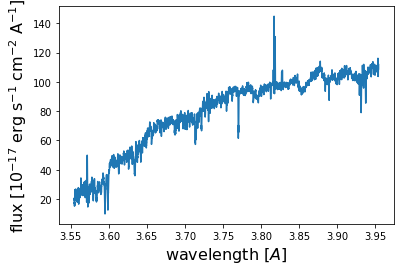

In [4]:
plt.plot(logwave, flux[0, :])
plt.ylabel('flux [$10^{−17}$ erg s$^{−1}$ cm$^{−2}$ A$^{-1}$]', fontsize = 16)
plt.xlabel('wavelength [$A$]', fontsize = 16)

# hint: look for Lyman series (emission lines of hydrogen)



In [5]:
# find normalization over wavelength for each galaxy
flux_sum = np.sum(flux, axis = 1)

In [6]:
flux_normalized = flux/np.tile(flux_sum, (np.shape(flux)[1], 1)).T

(0.0, 2.0)

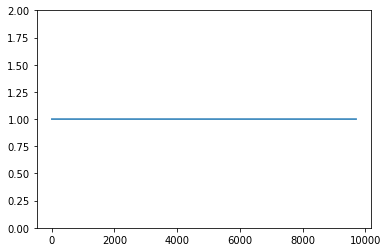

In [7]:
# check that the data is properly "normalized"
plt.plot(np.sum(flux_normalized, axis = 1))
plt.ylim(0,2)

In [8]:
# subtract off mean
means_normalized = np.mean(flux_normalized, axis=1)

In [9]:
flux_normalized_0_mean = flux_normalized-np.tile(means_normalized, (np.shape(flux)[1], 1)).T

Text(0.5, 0, 'wavelength [$A$]')

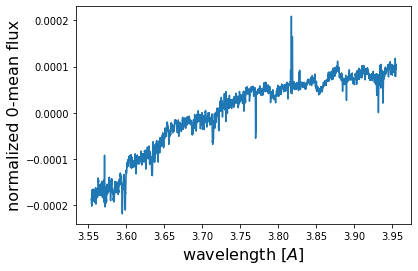

In [10]:
plt.plot(logwave, flux_normalized_0_mean[0,:])
plt.ylabel('normalized 0-mean flux', fontsize = 16)
plt.xlabel('wavelength [$A$]', fontsize = 16)

In [11]:
def sorted_eigs(r, return_eigvalues = False):
    """
    Calculate the eigenvectors and eigenvalues of the correlation matrix of r
    -----------------------------------------------------
    """
    corr=r.T@r
    eigs=np.linalg.eig(corr) #calculate eigenvectors and values of original 
    arg=np.argsort(eigs[0])[::-1] #get indices for sorted eigenvalues
    eigvec=eigs[1][:,arg] #sort eigenvectors
    eig = eigs[0][arg] # sort eigenvalues
    if return_eigvalues == True:
        return eig, eigvec
    else:
        return eigvec




In [12]:
# here I'll use data for only the first 500 galaxies because my computer is slow!
r = flux_normalized_0_mean 
r_subset = r[:500, :]
logwave_subset = logwave
C = r_subset.T@r_subset # correlation matrix, dimension # wavelengths x # wavelengths

In [13]:
# check dimensions of correlation matrix
C.shape

(4001, 4001)

In [14]:
# check dimension of data matrix for 500 galaxies
r_subset.shape

(500, 4001)

### First, use SVD to find the eigenvectors and eigenvalues

Recall SVD for our data matrix R:

\begin{equation}
R = U D V^T 
\end{equation}

where U is a matrix where our left singular vectors are columns, D is a diagonal matrix, and V^T is a matrix where are right singular vectors are columns.

The diagonal elements of D are called the singular values.

You probably are wondering how these "singular vectors" are related to the eigenvectors of the correlation matrix of the zero-mean, normalized data
\begin{equation}
C = R^T R
\end{equation}
and how these "singular values" are related to the eigenvalues of $C$.

Don't worry, I wrote down the answer!

\begin{equation}
R^T R=(UDV^T)^TUDV^T = VDU^TUDV^T = VD^2V^T
\end{equation}

Note that this is the eigensystem for $C$! So cool!

\begin{equation}
R^T R V^T= D^2V^T
\end{equation}

So $V^T$ contains the eigenvectors of $C$ and the diagonal elements of $D$ are the square roots of the eigenvalues of $C$.

Linear algebra is magic (when you do it correctly LOL!) :)

In [15]:
U, S, Vh = np.linalg.svd(r_subset, full_matrices=True)
# rows of Vh are eigenvectors
eigvecs_svd = Vh.T
eigvals_svd = S**2
svd_sort = np.argsort(eigvals_svd)[::-1]
eigvecs_svd = eigvecs_svd[:,svd_sort]
eigvals_svd = eigvals_svd[svd_sort]

### Use Eig to find the eigenvectors and eigenvalues

In [16]:
eigvals, eigvecs = sorted_eigs(r_subset, return_eigvalues = True)

### Comparing SVD and Eig eigenvectors and eigenvalues: a crisis?

We hope that our 2 methods of finding eigenvalues and eigenvectors give us the same eigenvectors, so I plot the eigenvectors from each method against one another.

Oh no! It looks like some of the SVD eigenvectors are reflected across the x axis...

But don't worry, I'll explain why this is the case below :)

Text(0, 0.5, 'Eig eigenvalues')

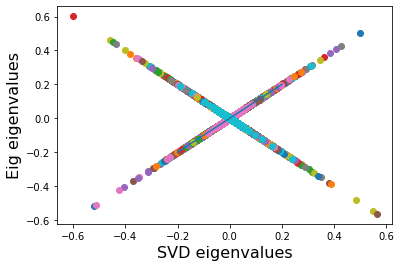

In [17]:
[plt.plot(eigvecs_svd[:,i], eigvecs[:,i], 'o')for i in range(500)]
plt.plot(np.linspace(-0.2, 0.2), np.linspace(-0.2, 0.2))
plt.xlabel('SVD eigenvalues', fontsize = 16)
plt.ylabel('Eig eigenvalues', fontsize = 16)

### Okay, so why are some of the eigenvectors we got using SVD reflected across x = 0? 

See https://stackoverflow.com/questions/44765682/in-sklearn-decomposition-pca-why-are-components-negative/44847053#44847053

It turns out the the eigenvectors found via SVD are unique up to a sign change between the left and right singular vectors!

This is because we can write the SVD of the normalized, mean-subtracted data matrix as

\begin{equation}
R = U D V^T = \sum d_i u_i v_i^T
\end{equation}
where $V^T$ is the matrix of right singular vectors and $U$ is the matrix of left singular vectors. So if there is a negative sign in the product $u_i v_i^T$, then I can put this negative sign in either  $u_i$ or $v_i^T$.

Below I check that the eigenvalues match between the eig and SVD methods and everything looks okay here.

Text(0, 0.5, 'Eig eigenvalues')

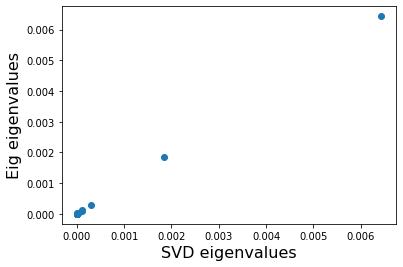

In [18]:
plt.plot(eigvals_svd, eigvals[:500], 'o')
plt.xlabel('SVD eigenvalues', fontsize = 16)
plt.ylabel('Eig eigenvalues', fontsize = 16)

### Now it's time to do the PCA dimensionality reduction


Here's how to do the PCA dimensionality reduction:

1) Get the eigenvalues and eigenvectors of the correlation matrix C (either with eig or SVD). 

2) Project $R$ onto the $l$ eigenvectors with the largest $l$ eigenvalues. This gives you a $N\times l$ matrix $W$ where $N$ is the number of galaxies (in this case 500 since my computer is slow!). This matrix represents the "weight" for each eigenvector. Here we've reduced the dimensionality of $R$ to $l$. This is relevant to part (g) of your homework 6.

3) Multiply each eigenvector by its weight to "filter" the original signal. If the eigenvector matrix $V^T$ is $M \times l$ where $M$ is the number of wavelengths, then the filtered $R$ matrix is 
\begin{equation}
R' = W V
\end{equation}
This is relevant to part (g) of your homework 6.

In [19]:
def PCA(l, r, project = True):
    """
    Perform PCA dimensionality reduction
    --------------------------------------------------------------------------------------
    """
    eigvector = sorted_eigs(r)
    eigvec=eigvector[:,:l] #sort eigenvectors, only keep l
    reduced_wavelength_data= np.dot(eigvec.T,r.T) #np.dot(eigvec.T, np.dot(eigvec,r.T))
    if project == False:
        return reduced_wavelength_data.T # get the reduced wavelength weights
    else: 
        return np.dot(eigvec, reduced_wavelength_data).T # multiply eigenvectors by 
                                                        # weights to get approximate spectrum


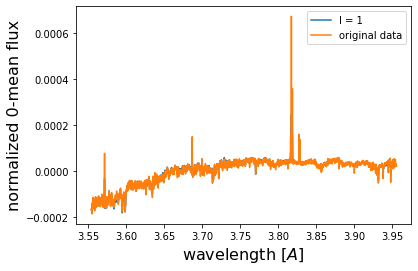

In [20]:
# Using only the first eigenvector does not capture the entire signal well! 
plt.plot(logwave_subset, PCA(1,r_subset)[1,:], label = 'l = 1')
plt.plot(logwave_subset, r_subset[1,:], label = 'original data')

plt.ylabel('normalized 0-mean flux', fontsize = 16)
plt.xlabel('wavelength [$A$]', fontsize = 16)
plt.legend()

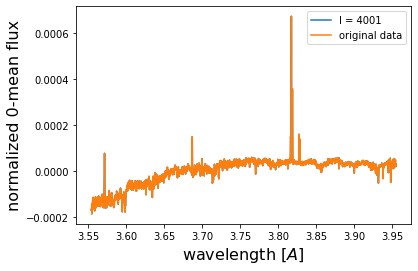

In [21]:
# check to make sure that using all eigenvectors reconstructs original signal
plt.plot(logwave_subset, PCA(4001,r_subset)[1,:], label = 'l = 4001')
plt.plot(logwave_subset, r_subset[1,:], label = 'original data')

plt.ylabel('normalized 0-mean flux', fontsize = 16)
plt.xlabel('wavelength [$A$]', fontsize = 16)
plt.legend()